***STEP 2***

---



# DATA COLLECTION

In [ ]:

!unzip  "/content/rvmmodel2.zip"

Archive:  /content/rvmmodel2.zip
  inflating: rvm/defective/tijen_sbsm4.jpg  
  inflating: rvm/defective/tijen_sbsm0.jpg  
  inflating: rvm/defective/baya_sbsm02.jpg  
  inflating: rvm/defective/aqualine_sbsm20.jpg  
  inflating: rvm/defective/baya0.jpg  
  inflating: rvm/defective/baya_sbsm01.jpg  
  inflating: rvm/defective/marwa_sbsm00.jpg  
  inflating: rvm/defective/marwa_sbsm2.jpg  
  inflating: rvm/defective/marwa_sbsm1.jpg  
  inflating: rvm/defective/aqualine_sbsm2.jpg  
  inflating: rvm/defective/marwa_sbsm3.jpg  
  inflating: rvm/defective/aqualine_sbsm21.jpg  
  inflating: rvm/defective/dima_sbsm3.jpg  
  inflating: rvm/defective/aqualine_sbsm22.jpg  
  inflating: rvm/defective/aqualine_sbsm3.jpg  
  inflating: rvm/defective/aqualine_sbsm0.jpg  
  inflating: rvm/defective/marwa_sbsm4.jpg  
  inflating: rvm/defective/baya_sbsm00.jpg  
  inflating: rvm/defective/aqualine_sbsm1.jpg  
  inflating: rvm/defective/aqualine_sbsm4.jpg  
  inflating: rvm/defective/dima_sbsm4.jpg  
  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from keras.preprocessing.image import ImageDataGenerator
import cv2
warnings.filterwarnings('ignore')

In [ ]:
filenames = glob.glob("/content/drive/MyDrive/DATAMODELE2/*/*.jpg")
print(len(filenames))
start = "/content/drive/MyDrive/DATAMODELE2"
relative_paths=[]
categories = []

for filename in filenames:
    rp = os.path.relpath(filename, start)
    relative_path = rp.split('/')[0] 
    relative_paths.append(relative_path)
    
df = pd.DataFrame({
    'image': filenames,
    'label': relative_paths
})


df

510


image          label
0    /content/drive/MyDrive/DATAMODELE2/defective/c...      defective
1    /content/drive/MyDrive/DATAMODELE2/defective/c...      defective
2    /content/drive/MyDrive/DATAMODELE2/defective/c...      defective
3    /content/drive/MyDrive/DATAMODELE2/defective/c...      defective
4    /content/drive/MyDrive/DATAMODELE2/defective/c...      defective
..                                                 ...            ...
505  /content/drive/MyDrive/DATAMODELE2/non-defecti...  non-defective
506  /content/drive/MyDrive/DATAMODELE2/non-defecti...  non-defective
507  /content/drive/MyDrive/DATAMODELE2/non-defecti...  non-defective
508  /content/drive/MyDrive/DATAMODELE2/non-defecti...  non-defective
509  /content/drive/MyDrive/DATAMODELE2/non-defecti...  non-defective

[510 rows x 2 columns]

In [ ]:
df['image'][0]

'/content/drive/MyDrive/rvm/defective/ORANGINA_SM6.jpg'

DATA UNDERSTANDING+DATA PREPARATION 


In [ ]:
import plotly.offline as po
import plotly.graph_objs as go


plot_by_class_labels = df["label"].value_counts().keys().tolist()

plot_by_class_values = df["label"].value_counts().values.tolist()

plot_data= [
    go.Pie(labels = plot_by_class_labels,
           values = plot_by_class_values,
           marker = dict(colors =  [ 'Teal' ,'Grey','Red','Yellow','Green'],
                         line = dict(color = "white",
                                     width =  1.5)),
           rotation = 100,
           hoverinfo = "label+value+text",
           hole = .6)
]
plot_layout = go.Layout(dict(title = "",
                   plot_bgcolor  = "rgb(243,243,243)",
                   paper_bgcolor = "rgb(243,243,243)",))


fig = go.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

In [ ]:
df['label'].value_counts()

non-defective    320
defective        190
Name: label, dtype: int64

In [ ]:
df.duplicated().values.any()

False

<Axes: >

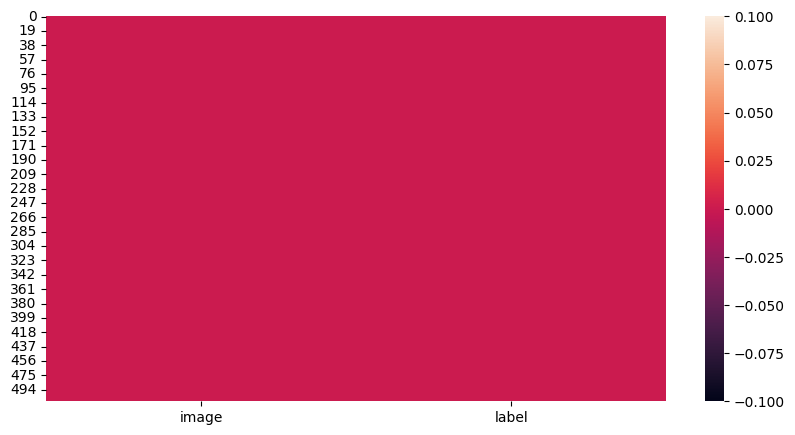

In [ ]:
#Heatmap qui montre les valeurs manquantes
plt.figure(figsize=(10,5))
sns.heatmap(df.isna(), cbar=True)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#We need to normalize image
datagentrain = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,rescale=1./255)
datagentest = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,rescale=1./255)


In [ ]:
datagentrain = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                                  brightness_range=[0.1,1.0]
                                 )
datagentest = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagentrain.mean = np.array([127.5, 127.5, 127.5], dtype=np.float32).reshape((1,1,3))
datagentrain.std = 255.0
datagentest.mean = np.array([127.5, 127.5, 127.5], dtype=np.float32).reshape((1,1,3))
datagentest.std = 255.0

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,test_size = 0.25, stratify=df.label)


In [ ]:
traingenerator = datagentrain.flow_from_dataframe( train_df , './',x_col = 'image' , y_col = 'label',    target_size=(340, 768),
                                                    batch_size=32,
                                                    class_mode='categorical')
testgenerator = datagentest.flow_from_dataframe( test_df , './',x_col = 'image' , y_col = 'label',    target_size=(340, 768),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 382 validated image filenames belonging to 2 classes.
Found 128 validated image filenames belonging to 2 classes.


DATA MODELING

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



# Créer les générateurs de données à l'aide de ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='image',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='image',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

# Définir la fonction pour créer le modèle
def create_model(input_shape=(100, 100, 3), num_classes=5,activation='relu',optimizer='adam'):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation=activation),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation=activation),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Définir les hyperparamètres à tester
param_grid = {
    'input_shape': [(100, 100, 3), (200, 200, 3)],
    'num_classes': [2],
    'batch_size': [32, 64,128],
    'epochs': [10, 20,30],
'optimizer' : ['rmsprop', 'adam', 'sgd'],
'activation' :['relu', 'tanh','elu']
}

# Créer un objet GridSearchCV
grid_search = GridSearchCV(estimator=KerasClassifier(create_model),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3)



Found 382 validated image filenames belonging to 2 classes.
Found 128 validated image filenames belonging to 2 classes.


In [ ]:
# Exécuter la recherche sur grille
x_train, y_train = next(train_generator)

grid_search.fit(x_train,y_train)



Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6922 - accuracy: 0.5714
Epoch 2/10
1/1 [==============================] - 0s 295ms/step - loss: 2.9023 - accuracy: 0.5238
Epoch 3/10
1/1 [==============================] - 0s 306ms/step - loss: 3.8067 - accuracy: 0.4286
Epoch 4/10
1/1 [==============================] - 0s 291ms/step - loss: 0.6398 - accuracy: 0.5714
Epoch 5/10
1/1 [==============================] - 0s 292ms/step - loss: 0.6492 - accuracy: 0.5714
Epoch 6/10
1/1 [==============================] - 0s 322ms/step - loss: 0.5254 - accuracy: 0.9524
Epoch 7/10
1/1 [==============================] - 0s 294ms/step - loss: 0.7533 - accuracy: 0.5238
Epoch 8/10
1/1 [==============================] - 0s 289ms/step - loss: 0.7222 - accuracy: 0.5238
Epoch 9/10
1/1 [==============================] - 0s 298ms/step - loss: 0.6615 - accuracy: 0.5714
Epoch 10/10
1/1 [==============================] - 0s 238ms/step
Epoch 1/10
1/1 [==============================] - 1s 1s/

1/1 [==============================] - 0s 126ms/step
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6852 - accuracy: 0.5909
Epoch 2/10
1/1 [==============================] - 0s 298ms/step - loss: 1.7486 - accuracy: 0.5909
Epoch 3/10
1/1 [==============================] - 0s 300ms/step - loss: 1.0229 - accuracy: 0.5909
Epoch 4/10
1/1 [==============================] - 0s 325ms/step - loss: 0.7173 - accuracy: 0.5909
Epoch 5/10
1/1 [==============================] - 0s 303ms/step - loss: 0.7732 - accuracy: 0.6364
Epoch 6/10
1/1 [==============================] - 0s 300ms/step - loss: 0.5181 - accuracy: 0.6818
Epoch 7/10
1/1 [==============================] - 0s 329ms/step - loss: 0.7146 - accuracy: 0.6364
Epoch 8/10
1/1 [==============================] - 0s 325ms/step - loss: 0.6265 - accuracy: 0.5909
Epoch 9/10
1/1 [==============================] - 1s 539ms/step - loss: 0.5276 - accuracy: 0.7727
Epoch 10/10
1/1 [==============================] - 1s 582ms/step - l

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 28/30
1/1 [==============================] - 1s 548ms/step - loss: 2.2780 - accuracy: 0.4286
Epoch 29/30
1/1 [==============================] - 1s 604ms/step - loss: 2.5191 - accuracy: 0.3810
Epoch 30/30
1/1 [==============================] - 0s 111ms/step
Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.6296 - accuracy: 0.6818
Epoch 2/30
1/1 [==============================] - 0s 365ms/step - loss: 2.3775 - accuracy: 0.5909
Epoch 3/30
1/1 [==============================] - 0s 393ms/step - loss: 1.3889 - accuracy: 0.5909
Epoch 4/30
1/1 [==============================] - 0s 405ms/step - loss: 1.4099 - accuracy: 0.4545
Epoch 5/30
1/1 [==============================] - 1s 505ms/step - loss: 1.0837 - accuracy: 0.5455
Epoch 6/30
1/1 [==============================] - 1s 595ms/step - loss: 1.2819 - accuracy: 0.5455
Epoch 7/30
1/1 [==============================] - 1s 584ms/step - loss: 1.

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdf3afa81f0>,
             param_grid={'activation': ['relu', 'tanh', 'elu'],
                         'batch_size': [32, 64, 128], 'epochs': [10, 20, 30],
                         'input_shape': [(100, 100, 3), (200, 200, 3)],
                         'num_classes': [2],
                         'optimizer': ['rmsprop', 'adam', 'sgd']},
             scoring='accuracy')

In [ ]:
# Afficher les meilleurs hyperparamètres et le score correspondant
print('Best hyperparameters:', grid_search.best_params_)
print('Best accuracy:', grid_search.best_score_)

# Utiliser le meilleur modèle pour prédire les étiquettes de la validation
best_model = grid_search.best_estimator_.model
validation_loss, validation_acc = best_model.evaluate(validation_generator, verbose=2)
print('Validation accuracy:', validation_acc)


Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'epochs': 10, 'input_shape': (100, 100, 3), 'num_classes': 2, 'optimizer': 'rmsprop'}
Best accuracy: nan
4/4 - 6s - loss: 0.6796 - accuracy: 0.6250 - 6s/epoch - 1s/step
Validation accuracy: 0.625


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

# Créer votre modèle en utilisant les meilleurs hyperparamètres
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

optimizer = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Entraîner le modèle avec les meilleurs hyperparamètres
model.fit_generator(train_generator
  ,
    epochs=10,
    validation_data=validation_generator
)

# Enregistrer le modèle en tant que fichier H5
model.save('rvmP2.h5')


Epoch 1/10
12/12 [==============================] - 27s 2s/step - loss: 0.9306 - accuracy: 0.5524 - val_loss: 0.6554 - val_accuracy: 0.6250
Epoch 2/10
12/12 [==============================] - 24s 2s/step - loss: 0.6467 - accuracy: 0.6414 - val_loss: 0.7381 - val_accuracy: 0.6250
Epoch 3/10
12/12 [==============================] - 28s 2s/step - loss: 0.6574 - accuracy: 0.6309 - val_loss: 0.6651 - val_accuracy: 0.6875
Epoch 4/10
12/12 [==============================] - 24s 2s/step - loss: 0.5826 - accuracy: 0.7277 - val_loss: 0.6027 - val_accuracy: 0.6406
Epoch 5/10
12/12 [==============================] - 23s 2s/step - loss: 0.5282 - accuracy: 0.7304 - val_loss: 0.5861 - val_accuracy: 0.7188
Epoch 6/10
12/12 [==============================] - 23s 2s/step - loss: 0.4611 - accuracy: 0.7775 - val_loss: 0.5622 - val_accuracy: 0.7344
Epoch 7/10
12/12 [==============================] - 25s 2s/step - loss: 0.4119 - accuracy: 0.8141 - val_loss: 0.5260 - val_accuracy: 0.7578
Epoch 8/10
12/12 [==

In [ ]:
#VGG16
import os
import zipfile
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input



In [ ]:
IMG_SHAPE = (340, 768,3)
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


58889256/58889256 [==============================] - 1s 0us/step


In [ ]:

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 340, 768, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 340, 768, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 340, 768, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 170, 384, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 170, 384, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 170, 384, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 85, 192, 128)      0     

In [ ]:
base_model.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)
     

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 340, 768, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 340, 768, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 340, 768, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 170, 384, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 170, 384, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 170, 384, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 85, 192, 128)      0   

In [ ]:

model.compile(  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
model.fit_generator(traingenerator, epochs=5, validation_data=testgenerator)


Epoch 1/5
12/12 [==============================] - 1735s 147s/step - loss: 2.0866 - accuracy: 0.5524 - val_loss: 1.2661 - val_accuracy: 0.6641
Epoch 2/5
12/12 [==============================] - 1721s 147s/step - loss: 0.5799 - accuracy: 0.7251 - val_loss: 0.4296 - val_accuracy: 0.8359
Epoch 3/5
12/12 [==============================] - 1734s 147s/step - loss: 0.3639 - accuracy: 0.8403 - val_loss: 0.2807 - val_accuracy: 0.9219
Epoch 4/5
12/12 [==============================] - 1701s 145s/step - loss: 0.4538 - accuracy: 0.8010 - val_loss: 0.2409 - val_accuracy: 0.9375
Epoch 5/5
12/12 [==============================] - 1718s 147s/step - loss: 0.3609 - accuracy: 0.8429 - val_loss: 0.2851 - val_accuracy: 0.8828


In [ ]:
model.save('rvmP2VGG16.h5')


In [ ]:
model.save('/content/drive/MyDrive/rvmP2VGG16.h5')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import pandas as pd
from PIL import Image


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
class YourDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        path = self.df.iloc[index]['image']
        label = self.df.iloc[index]['label']
        with open(path, 'rb') as f:
            img = Image.open(f)
            img.load()
        if self.transform is not None:
            img = self.transform(img)
        return img, label


In [ ]:
train_dataset = YourDataset(train_df, transform_train)
test_dataset = YourDataset(test_df, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
model = models.resnet18(pretrained=True)


In [ ]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print('Epoch: {}, Loss: {}'.format(epoch+1, running_loss/len(train_loader)))


Epoch: 1, Loss: 0.6609323769807816
Epoch: 2, Loss: 0.6668265412251154
Epoch: 3, Loss: 0.6668015271425247
Epoch: 4, Loss: 0.6614703039328257
Epoch: 5, Loss: 0.6728662500778834
Epoch: 6, Loss: 0.6664784451325735
Epoch: 7, Loss: 0.6688870986302694
Epoch: 8, Loss: 0.6718630393346151
Epoch: 9, Loss: 0.6733149886131287
Epoch: 10, Loss: 0.6594908585151037


In [ ]:
# Charger l'image
image = Image.open("/content/drive/MyDrive/DATAMODELE2/defective/BOGAL_SM5.jpg")

# Prétraiter l'image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image_tensor = transform(image).unsqueeze(0)

# Mettre le modèle en mode évaluation
resnet.eval()

# Passer l'image au modèle
with torch.no_grad():
    output = resnet(image_tensor.to(device))

# Obtenir la classe prédite
_, predicted = torch.max(output.data, 1)
print("Classe prédite:", predicted.item())


Classe prédite: 0


In [ ]:
# Charger l'image
image = Image.open("/content/drive/MyDrive/DATAMODELE2/non-defective/BARGOU_1.5L0.jpg")

# Prétraiter l'image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image_tensor = transform(image).unsqueeze(0)

# Mettre le modèle en mode évaluation
resnet.eval()

# Passer l'image au modèle
with torch.no_grad():
    output = resnet(image_tensor.to(device))

# Obtenir la classe prédite
_, predicted = torch.max(output.data, 1)
print("Classe prédite:", predicted.item())


Classe prédite: 0


In [ ]:
df.label.unique()


array(['defective', 'non-defective'], dtype=object)

EVALUATION

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
model=keras.models.load_model("/content/drive/MyDrive/rvmP2 (1).h5")
model_VGG=keras.models.load_model("/content/drive/MyDrive/rvmP2VGG16.h5")


In [ ]:
#accuracy :0.8770
#val_accuracy: 0.7969 for the first model

In [ ]:
#VGG MODEL
loss, accuracy = model_VGG.evaluate(traingenerator)

12/12 [==============================] - 341s 31s/step - loss: 0.3559 - accuracy: 0.7906


In [ ]:
#VGG MODEL
val_loss, val_accuracy = model_VGG.evaluate(testgenerator)


4/4 [==============================] - 6s 1s/step - loss: 0.1383 - accuracy: 0.9609


In [ ]:
resnet.eval()
total_correct = 0
total_images = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = 100 * total_correct / total_images
print('Accuracy on test set: {} %'.format(accuracy))


Accuracy on test set: 60.9375 %


In [ ]:

# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("/content/drive/MyDrive/rvmP2VGG16.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (100, 100)
    img = image.load_img(img_rel_path, target_size=(340, 768))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = df['label'].unique()

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")
    from collections import defaultdict
   



    for i,j in enumerate (p[0],0):
          
        
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

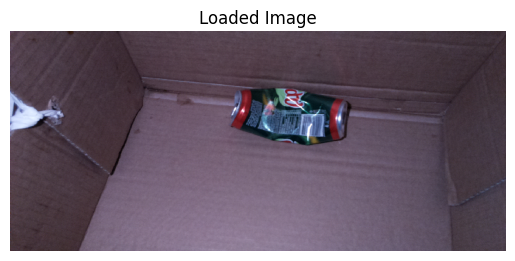

1/1 [==============================] - 2s 2s/step


Maximum Probability:  0.9999279
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 99.99 %
NON-DEFECTIVE : 0.01 %


In [ ]:
predict('/content/drive/MyDrive/DATAMODELE2/defective/APLA5.jpg')

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
def predict_modele_2(path):
          # Load the image
          img = Image.open(path)

          # Resize the image to the input shape of the model
          img = img.resize((768, 340))

          # Convert the image to a numpy array
          img_array = np.array(img)

          # Expand the dimensions of the array to match the input shape of the model
          img_array = np.expand_dims(img_array, axis=0)

          # Load the model
          model = tf.keras.models.load_model("/content/drive/MyDrive/rvmP2VGG16.h5")

          # Make a prediction
          prediction = model.predict(img_array)
          # Load the class names
          class_names = ["defective","non_defective"]

          # Make a prediction
          prediction = model.predict(img_array)

          # Get the predicted class index
          predicted_class_index = np.argmax(prediction)

          # Get the name of the predicted class
          predicted_class_name = class_names[predicted_class_index]

          # Print the predicted class name
          print(predicted_class_name)
          return predicted_class_name



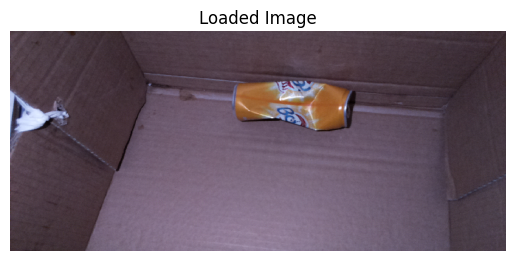

1/1 [==============================] - 0s 23ms/step


Maximum Probability:  0.9996055
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 99.96 %
NON-DEFECTIVE : 0.04 %


In [ ]:
predict("/content/drive/MyDrive/DATAMODELE2/defective/BOGAC_SM2.jpg")

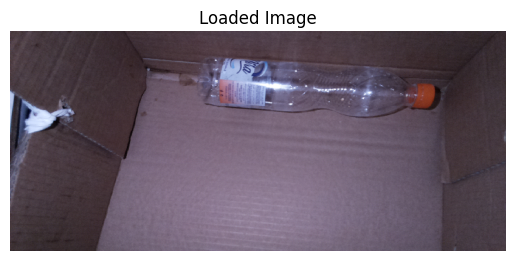

1/1 [==============================] - 0s 22ms/step


Maximum Probability:  0.9386335
Classified: non-defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 6.14 %
NON-DEFECTIVE : 93.86 %


In [ ]:
predict("/content/drive/MyDrive/DATAMODELE3/PLASTIC_0.5L/MIRA_2.jpg")

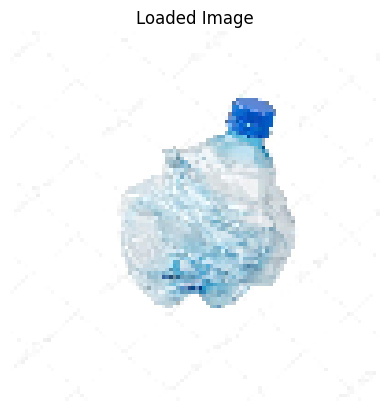

1/1 [==============================] - 0s 105ms/step


Maximum Probability:  0.71966755
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 71.97 %
NON-DEFECTIVE : 28.03 %


In [ ]:
predict("/content/depositphotos_41733181-stock-photo-smashed-plastic-bottle.jpg")


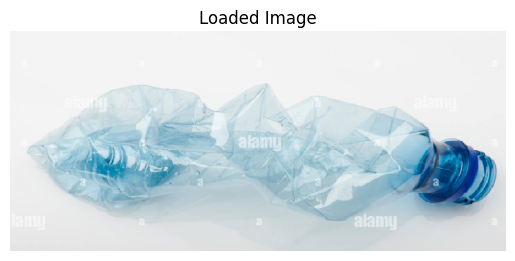

1/1 [==============================] - 0s 23ms/step


Maximum Probability:  0.67244744
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 67.24 %
NON-DEFECTIVE : 32.76 %


In [ ]:
predict("/content/Capture.PNG")

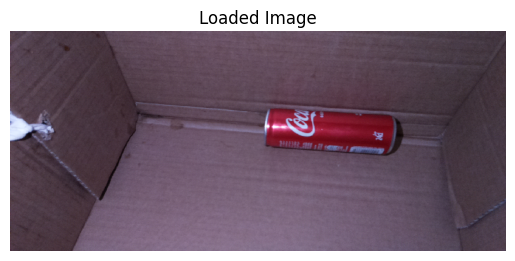

1/1 [==============================] - 0s 27ms/step


Maximum Probability:  0.9414469
Classified: non-defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 5.86 %
NON-DEFECTIVE : 94.14 %


In [ ]:
predict("/content/drive/MyDrive/DATAMODELE3/CANETTE/COCA1.jpg")

In [ ]:
predict_modele_2('/content/drive/MyDrive/DATAMODELE2/defective/APLA5.jpg')

1/1 [==============================] - 2s 2s/step
defective


'defective'

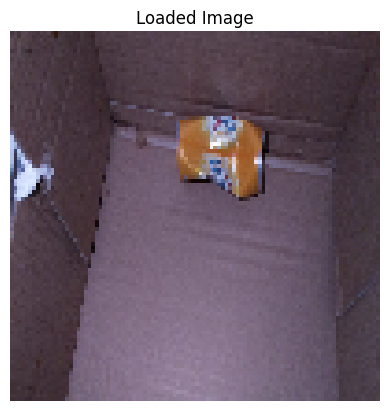

1/1 [==============================] - 0s 213ms/step


Maximum Probability:  0.6032279
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 60.32 %
NON-DEFECTIVE : 39.68 %


In [ ]:
predict1("/content/drive/MyDrive/DATAMODELE2/defective/BOGAC_SM2.jpg")

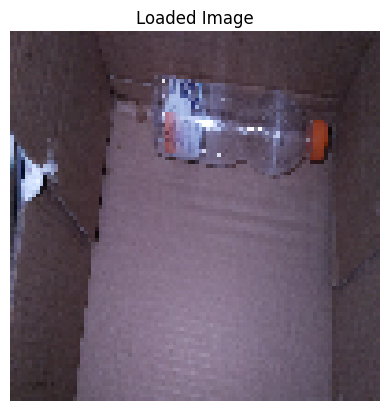

1/1 [==============================] - 0s 113ms/step


Maximum Probability:  0.9007306
Classified: non-defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 9.93 %
NON-DEFECTIVE : 90.07 %


In [ ]:
predict1("/content/drive/MyDrive/DATAMODELE3/PLASTIC_0.5L/MIRA_2.jpg")

In [ ]:
import tensorflow as tf
import numpy as np


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo2.jpg
(768, 340, 3)


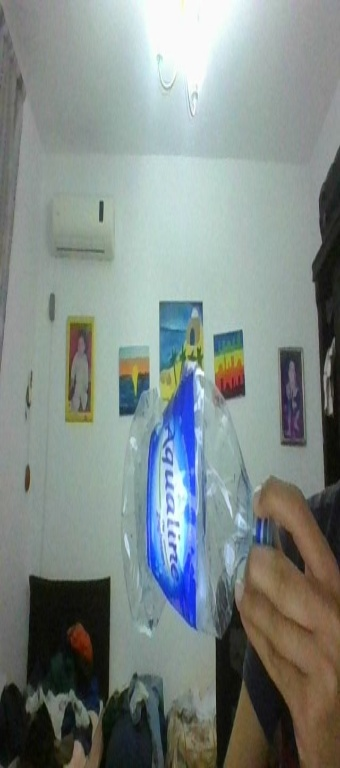

In [ ]:
try:
  filename = take_photo('photo2.jpg')
  print('Saved to {}'.format(filename))
  # Charger l'image
  img = cv2.imread("/content/photo2.jpg")
  # Redimensionner l'image en utilisant cv2.resize()
  resized_img = cv2.resize(img, (340, 768))
  # Afficher les dimensions de l'image redimensionnée
  print(resized_img.shape)
  cv2.imwrite("/content/photo2.jpg", resized_img)
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

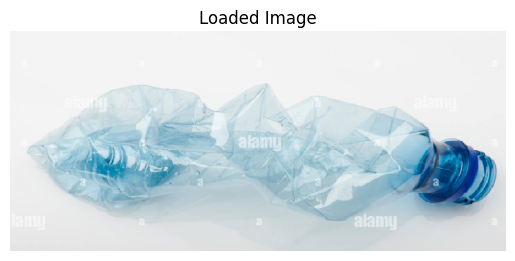

1/1 [==============================] - 6s 6s/step


Maximum Probability:  0.6724476
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 67.24 %
NON-DEFECTIVE : 32.76 %


In [ ]:
predict("/content/Capture.PNG")


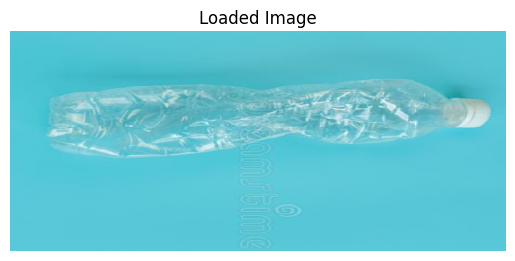

1/1 [==============================] - 5s 5s/step


Maximum Probability:  0.5756702
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 57.57 %
NON-DEFECTIVE : 42.43 %


In [ ]:
predict("/content/Capture1.PNG")


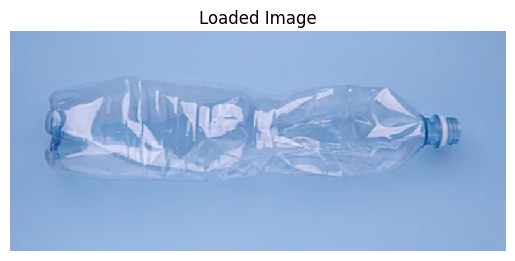

1/1 [==============================] - 4s 4s/step


Maximum Probability:  0.90892863
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 90.89 %
NON-DEFECTIVE : 9.11 %


In [ ]:
predict("/content/Capture3.PNG")


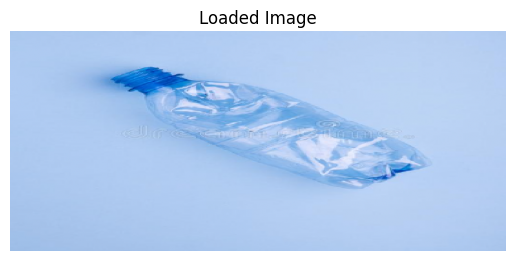

1/1 [==============================] - 4s 4s/step


Maximum Probability:  0.9950708
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 99.51 %
NON-DEFECTIVE : 0.49 %


In [ ]:
predict("/content/Capture4.PNG")


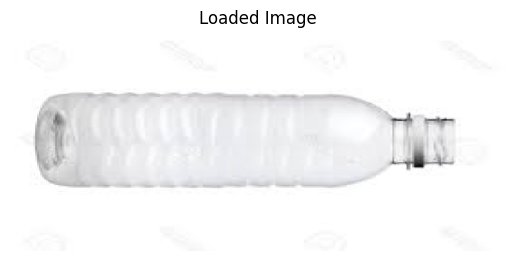

1/1 [==============================] - 6s 6s/step


Maximum Probability:  0.81996953
Classified: non-defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 18.0 %
NON-DEFECTIVE : 82.0 %


In [ ]:
predict("/content/bout1.png")


In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (16.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
img = cv2.imread('/content/images.png')


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

In [ ]:
import pytesseract

text = pytesseract.image_to_string(gray)


In [ ]:
words = text.split()

if words:
    largest_word = max(words, key=len)
    print("The largest word in the image is:", largest_word)
else:
    print("No words found in the image.")

The largest word in the image is: OCR’


In [ ]:
print("The largest word in the image is:", largest_word)


In [ ]:
model =  keras.models.load_model('/content/model_tacc8275_val8493.h5')


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Charger l'image à prédire
img_path = '/content/drive/MyDrive/DATAMODELE2/defective/APLA6.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Prétraiter l'image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Charger le modèle

# Faire une prédiction sur l'image
predictions = model.predict(img_array)


1/1 [==============================] - 0s 461ms/step


In [ ]:
def predict(img_rel_path):
    img = image.load_img(img_rel_path, target_size=(150, 150))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])

    # Label array
    labels = ['Defective','Proper']

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")
    from collections import defaultdict
   



    for i,j in enumerate (p[0],0):
          
        
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

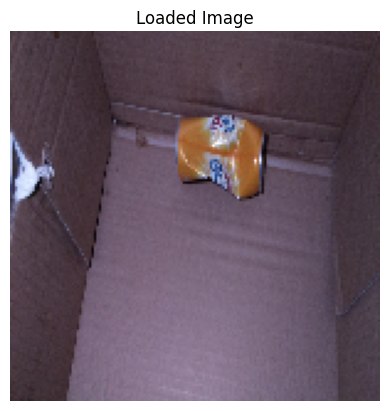

1/1 [==============================] - 0s 119ms/step


Maximum Probability:  0.6921483
Classified: Defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 69.21 %


In [ ]:
predict("/content/drive/MyDrive/DATAMODELE2/defective/BOGAC_SM2.jpg")

In [ ]:
path ='/content/drive/MyDrive/DATAMODELE3/PLASTIC_0.5L/aqualine10.jpg'
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]<0.5:
    print("Bottle is Defective")
else:
    print("Bottle is non-Defective")

1/1 [==============================] - 0s 60ms/step
[1.]
Bottle is non-Defective


In [ ]:
keras.__version__
tf.__version__

'2.12.0'

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Chargement du modèle
interpreter = tf.lite.Interpreter(model_path="/content/detection.tflite")
interpreter.allocate_tensors()

# Récupération des informations du modèle
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Chargement de l'image
image = Image.open('/content/drive/MyDrive/DATAMODELE3/PLASTIC_0.5L/aqualine10.jpg')
image = np.array(image.resize((input_details[0]['shape'][1], input_details[0]['shape'][2])))
image = np.expand_dims(image, axis=0)

# Exécution du modèle sur l'image
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Affichage des prédictions
print(output_data)


[[[ 3.72380376e-01  3.67205441e-01  5.77067018e-01  7.01227725e-01]
  [ 3.38904560e-03  9.45853829e-01  2.11962327e-01  9.96788144e-01]
  [ 8.44230950e-02  2.05874629e-03  3.50864500e-01  5.29930592e-02]
  [-8.19703937e-03  9.67895508e-01  2.65138686e-01  9.98906970e-01]
  [ 7.30969906e-02  9.48274493e-01  3.31506699e-01  9.96184349e-01]
  [ 6.88078254e-03  9.78684485e-01  2.24279881e-01  1.00083554e+00]
  [-4.23095226e-02  9.36412692e-01  1.90018639e-01  1.00259566e+00]
  [ 1.73947215e-02  2.33473815e-03  2.83836126e-01  5.81674948e-02]
  [ 1.42714351e-01  9.44153905e-01  3.78452688e-01  9.96671319e-01]
  [ 3.49093735e-01  2.83619434e-01  5.53780317e-01  7.66416192e-01]
  [-8.11278820e-04  9.37577784e-01  2.95582354e-01  9.98806298e-01]
  [ 5.30287623e-04  8.94171119e-01  1.84137180e-01  1.00668418e+00]
  [ 2.07724154e-01  8.62704590e-03  5.08867443e-01  5.36920018e-02]
  [ 3.66076708e-01  3.87910485e-01  5.32356262e-01  8.38560104e-01]
  [ 6.02284819e-03  8.09022844e-01  1.84095055e-

57


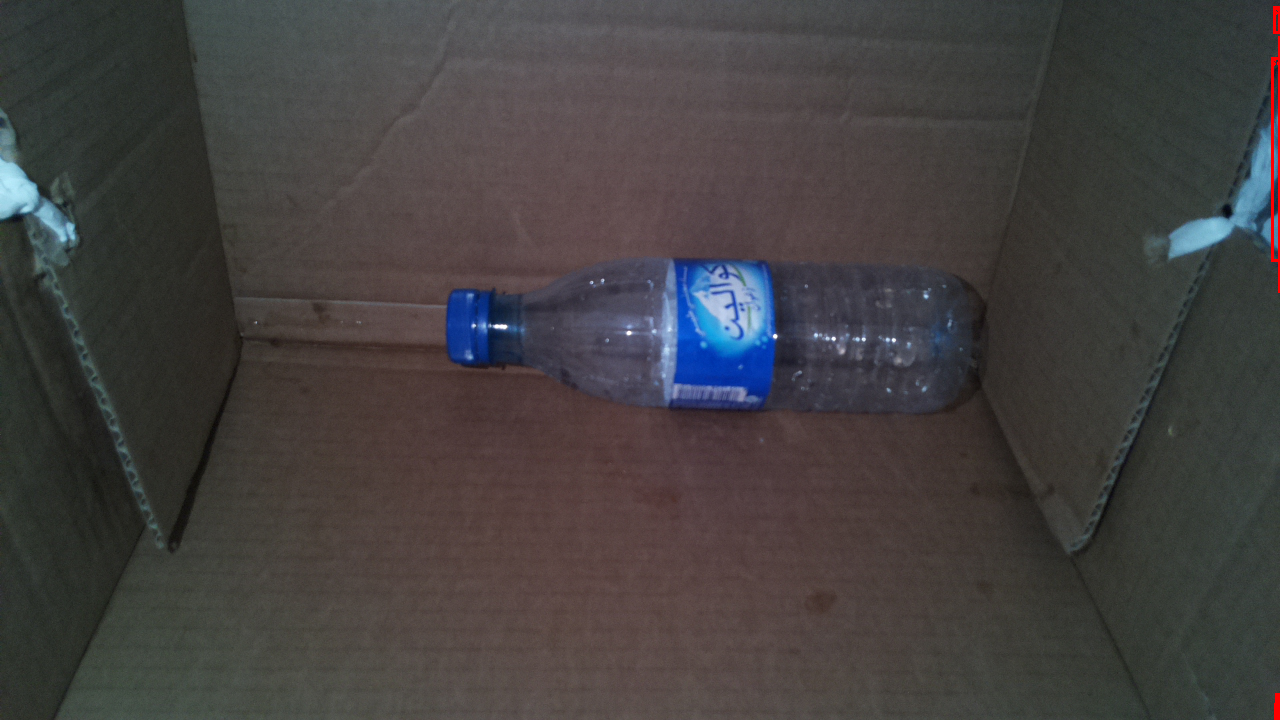

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw

# Chargement du modèle
interpreter = tf.lite.Interpreter(model_path="/content/detection.tflite")
interpreter.allocate_tensors()

# Récupération des informations du modèle
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Chargement de l'image
image_path = '/content/drive/MyDrive/DATAMODELE3/PLASTIC_0.5L/aqualine10.jpg'
image = Image.open(image_path)
image_np = np.array(image)
image_resized = image.resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))
input_data = np.expand_dims(image_resized, axis=0)

# Exécution du modèle sur l'image
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
# Récupération des informations sur les résultats de la détection
boxes = output_data[0][:, 1:5]
classes = output_data[0][:,3]
scores = output_data[0][:, 0]
print(len(boxes))

# Création d'un objet ImageDraw pour dessiner les résultats sur l'image
draw = ImageDraw.Draw(image)

# Parcours des résultats et dessin des boîtes englobantes et des scores associés
for i in range(57):
    if scores[i] > 0.5:  # Filtre des résultats en fonction des scores
        ymin, xmin, ymax = boxes[i][:3]
        xmax = 1
        (left, right, top, bottom) = (xmin * image.width, xmax * image.width, ymin * image.height, ymax * image.height)
        draw.rectangle((left, top, right, bottom), outline="red", width=3)
        draw.text((left, top), f"Score: {scores[i]:.2f}", fill="red")

# Affichage de l'image avec les résultats de la détection
image.show()


In [ ]:
import numpy as np
import tensorflow as tf

# Charger le modèle TFLite
interpreter = tf.lite.Interpreter(model_path="/content/detection.tflite")
interpreter.allocate_tensors()

# Obtenir les informations d'entrée et de sortie du modèle
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Charger l'image d'entrée
image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/DATAMODELE3/PLASTIC_0.5L/aqualine10.jpg', target_size=(512, 512))
input_data = np.expand_dims(tf.keras.preprocessing.image.img_to_array(image), axis=0)
input_data = np.uint8((input_data.astype(np.float32) - 127.5) / 127.5 * 128 + 128)  # Normaliser en UINT8

# Entrer l'image dans le modèle
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Récupérer les sorties du modèle
output_data = []
for i in range(len(output_details)):
    output_data.append(interpreter.get_tensor(output_details[i]['index']))

# Identifier les index de la classe "bottle" dans la sortie du modèle
class_labels = output_data[1][0]
print(class_labels)



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
import numpy as np
import tensorflow as tf
import tflite

# Load TFLite model.
interpreter = tf.lite.Interpreter(model_path="/content/tflite_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
!pip install tflite



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
from PIL import Image

# Load photo.
photo = Image.open("/content/drive/MyDrive/DATAMODELE3/CANETTE/COCA_SM1.jpg").convert("RGB")
photo = photo.resize((150, 200))
photo_array = np.array(photo).astype(np.float32)
photo_array = photo_array / 255.0
photo_array = np.expand_dims(photo_array, axis=0)
# Make prediction.
interpreter.set_tensor(input_details[0]['index'], photo_array)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])


# Define your labels.
labels = ['Metal 33CL Boga', 'Metal 33CL Coca', 'Plastique 100CL Coca',
       'Plastique 100CL Vahnia', 'Plastique 150CL Coca',
       'Plastique 150CL Marwa', 'Plastique 150CL Royale',
       'Plastique 150CL Sabrine', 'Plastique 150CL Safia',
       'Plastique 150CL Tijen', 'Plastique 2L Fourat',
       'Plastique 2L Jannet', 'Plastique 2L palma', 'Plastique 30CL Boga',
       'Plastique 30CL Coca', 'Plastique 30CL Fanta',
       'Plastique 50CL ElBehi', 'Plastique 50CL Fanta',
       'Plastique 50CL Melliti', 'Plastique 50CL Palma',
       'Plastique 50CL Royale', 'Plastique 50CL Safia']

# Get the index of the maximum value in the output tensor.
class_index = np.argmax(prediction)

# Get the corresponding label.
predicted_label = labels[class_index]

# Print the predicted label.
print("Predicted label:", predicted_label)



Predicted label: Plastique 2L Jannet


In [ ]:
print(photo_array)


[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]


Predicted label: Plastique 2L Jannet


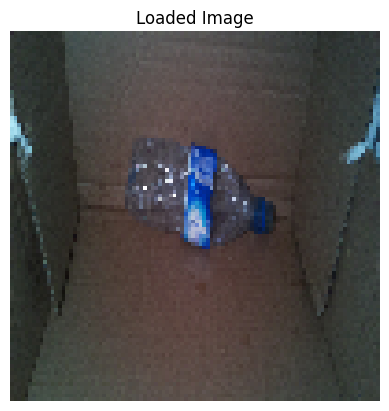

1/1 [==============================] - 0s 48ms/step


Maximum Probability:  0.97124803
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 97.12 %
NON-DEFECTIVE : 2.88 %


In [ ]:
predict("/content/aqualine_sbsm0.jpg")

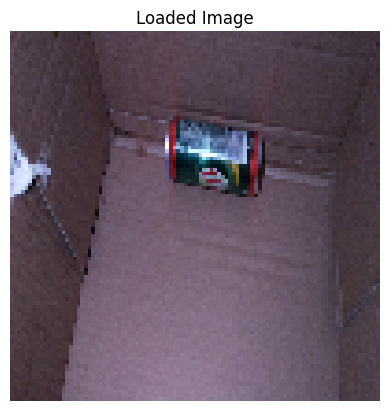

1/1 [==============================] - 0s 126ms/step


Maximum Probability:  0.6801032
Classified: non-defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 31.99 %
NON-DEFECTIVE : 68.01 %


In [ ]:
predict("/content/APLA4.jpg")

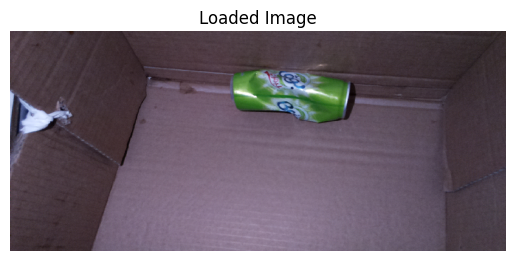

1/1 [==============================] - 3s 3s/step


Maximum Probability:  0.9965496
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 99.65 %
NON-DEFECTIVE : 0.35 %


In [ ]:
predict("/content/drive/MyDrive/rvm/defective/BOGAL_SM5.jpg")

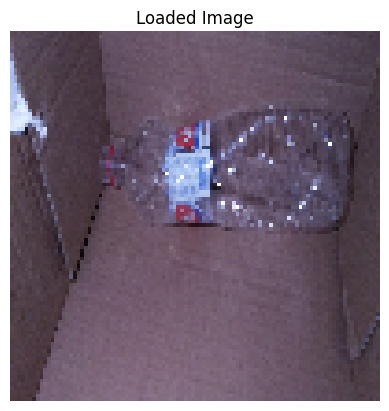

1/1 [==============================] - 0s 127ms/step


Maximum Probability:  0.9412453
Classified: defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 94.12 %
NON-DEFECTIVE : 5.88 %


In [ ]:
predict("/content/drive/MyDrive/rvm/defective/MELITI_1.5LSBSM1.jpg")


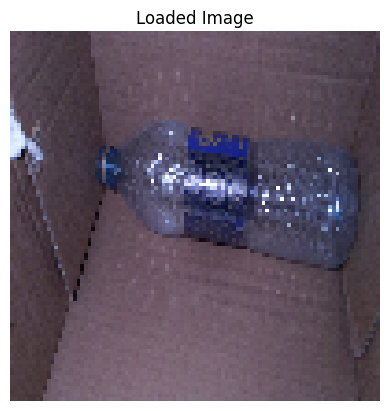

1/1 [==============================] - 0s 96ms/step


Maximum Probability:  0.98946464
Classified: non-defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 1.05 %
NON-DEFECTIVE : 98.95 %


In [ ]:
predict("/content/drive/MyDrive/rvm/non-defective/tijen_1.5Lsb1.jpg")


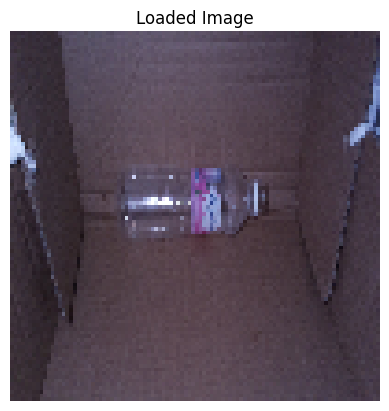

1/1 [==============================] - 0s 40ms/step


Maximum Probability:  0.94865835
Classified: non-defective 



-------------------Individual Probability--------------------------------

DEFECTIVE : 5.13 %
NON-DEFECTIVE : 94.87 %


In [ ]:
predict("/content/drive/MyDrive/rvm/non-defective/safia_sb0.jpg")


In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("/content/ASKepoch.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (100, 100)
    img = image.load_img(img_rel_path, target_size=(128, 128))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")
    from collections import defaultdict
   




    for i,j in enumerate (p[0],0):
          
        
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

In [ ]:
import cv2
import darknet

# Charger l'image
img = cv2.imread("chemin/vers/image.jpg")

# Charger le modèle YOLOv8
net = darknet.load_net_custom("chemin/vers/yolov8.cfg", "chemin/vers/yolov8.weights", 0, 1)

# Charger la liste des noms de classes
class_names = darknet.load_names("chemin/vers/classes.names")

# Convertir l'image en un format compatible avec Darknet
darknet_image = darknet.make_image(img.shape[1], img.shape[0], 3)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
darknet.copy_image_from_bytes(darknet_image, img_rgb.tobytes())

# Détecter les objets dans l'image
detections = darknet.detect_image(net, class_names, darknet_image)

# Dessiner des rectangles autour des bouteilles détectées
for detection in detections:
    name, confidence, (x, y, w, h) = detection
    if name.decode() == "bottle":
        left = int(x - w / 2)
        top = int(y - h / 2)
        right = int(x + w / 2)
        bottom = int(y + h / 2)
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

# Afficher l'image avec les bouteilles détectées
cv2.imshow("Bottle Detection", img)
cv2.waitKey(0)


ModuleNotFoundError: ignored

In [ ]:
!pip install darknetpy



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for darknetpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for darknetpy
Failed to build darknetpy
ERROR: Could not build wheels for darknetpy, which is required to install pyproject.toml-based projects


In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git


Cloning into 'darknet'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514
Receiving objects: 100% (15514/15514), 14.18 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.


In [ ]:
!cd  /content/drive/MyDrive/darknet

In [ ]:
!apt-get install build-essential


Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
!make


make: *** No targets specified and no makefile found.  Stop.


In [ ]:
!make install


make: *** No rule to make target 'install'.  Stop.


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514
Receiving objects: 100% (15514/15514), 14.18 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd /content/drive/MyDrive/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/drive/MyDrive/darknet


In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2023-04-15 23:58:13--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 142.251.2.113, 142.251.2.100, 142.251.2.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eep7hlre54m96enefh49qf7fpav83bg6/1681603050000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=69afd039-f9bd-4004-8658-1f84c8abeedf [following]
--2023-04-15 23:58:13--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eep7hlre54m96enefh49qf7fpav83bg6/1681603050000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=69afd039-f9bd-4004-8658-1f84c8abeedf
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 142.250.141.132, 260

In [ ]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/chemin/vers/cuda/lib64/


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2023-04-16 00:09:34--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 142.251.2.101, 142.251.2.102, 142.251.2.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v59l1o3rjuj5351cdf5kfn9lmjkaqsfb/1681603725000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=9fc34693-56ce-42c6-a63e-1b6e3081a624 [following]
--2023-04-16 00:09:34--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v59l1o3rjuj5351cdf5kfn9lmjkaqsfb/1681603725000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=9fc34693-56ce-42c6-a63e-1b6e3081a624
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 142.250.141.132, 260

# Nouvelle section

In [ ]:
!unzip  "/content/BRANDCAN.zip"

Archive:  /content/BRANDCAN.zip
   creating: BRANDCAN/
   creating: BRANDCAN/APPLA/
  inflating: BRANDCAN/APPLA/APLA0.jpg  
  inflating: BRANDCAN/APPLA/APLA1.jpg  
  inflating: BRANDCAN/APPLA/APLA2.jpg  
  inflating: BRANDCAN/APPLA/APLA3.jpg  
  inflating: BRANDCAN/APPLA/APLA4.jpg  
  inflating: BRANDCAN/APPLA/APLA5.jpg  
  inflating: BRANDCAN/APPLA/APLA6.jpg  
   creating: BRANDCAN/BOGA/
  inflating: BRANDCAN/BOGA/BOGAC0.jpg  
  inflating: BRANDCAN/BOGA/BOGAC1.jpg  
  inflating: BRANDCAN/BOGA/BOGAC2.jpg  
  inflating: BRANDCAN/BOGA/BOGAC3.jpg  
  inflating: BRANDCAN/BOGA/BOGAL0.jpg  
  inflating: BRANDCAN/BOGA/BOGAL1.jpg  
  inflating: BRANDCAN/BOGA/BOGAL2.jpg  
  inflating: BRANDCAN/BOGA/BOGAL3.jpg  
  inflating: BRANDCAN/BOGA/BOGAL4.jpg  
  inflating: BRANDCAN/BOGA/BOGAL5.jpg  
  inflating: BRANDCAN/BOGA/BOGAL6.jpg  
   creating: BRANDCAN/COCACOLA/
  inflating: BRANDCAN/COCACOLA/COCA0.jpg  
  inflating: BRANDCAN/COCACOLA/COCA1.jpg  
  inflating: BRANDCAN/COCACOLA/COCA2.jpg  
  infla

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(
        rotation_range=45, 
        zoom_range=0.2,
        fill_mode='constant', cval=125) 
import numpy as np
from skimage import io
import os
from PIL import Image




for batch in datagen.flow_from_directory(directory='/content/BRANDCAN/APPLA', 
                                         batch_size=16,  
                                         target_size=(256, 256),
                                         color_mode="rgb",
                                         save_to_dir='/content/BRANDCAN/APPLA', 
                                         save_prefix='aug', 
                                         save_format='jpg'):
    i += 1
    if i > 50:
        break

Found 0 images belonging to 0 classes.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(
        rotation_range=45, 
        zoom_range=0.2,
        fill_mode='constant', cval=125) 
import numpy as np
from skimage import io
import os
from PIL import Image

image_directory = '/content/appla'

SIZE = 340
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if '.' in image_name and image_name.split('.')[1] == 'jpg':
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        # rest of your code here
x = np.array(dataset)
x.shape
i = 0
for batch in datagen.flow_from_directory(directory='/content/appla', 
                                         batch_size=16,  
                                         target_size=(256, 256),
                                         color_mode="rgb",
                                         save_to_dir='/content/BRANDCAN/APPLA', 
                                         save_prefix='aug', 
                                         save_format='jpg'):
    i += 1
    if i > 15:
        break

Found 5 images belonging to 2 classes.


In [ ]:
import shutil
shutil.rmtree("/content/BRANDCAN/APPLA")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from keras.preprocessing.image import ImageDataGenerator
import cv2
warnings.filterwarnings('ignore')

In [ ]:
filenames = glob.glob("/content/drive/MyDrive/BRANDCAN/*/*.jpg")
print(len(filenames))
start = "/content/drive/MyDrive/BRANDCAN"
relative_paths=[]
categories = []

for filename in filenames:
    rp = os.path.relpath(filename, start)
    relative_path = rp.split('/')[0] 
    relative_paths.append(relative_path)
    
df = pd.DataFrame({
    'image': filenames,
    'label': relative_paths
})


df

406


image  label
0    /content/drive/MyDrive/BRANDCAN/BOGA/aug_10_75...   BOGA
1    /content/drive/MyDrive/BRANDCAN/BOGA/aug_4_362...   BOGA
2    /content/drive/MyDrive/BRANDCAN/BOGA/aug_9_243...   BOGA
3    /content/drive/MyDrive/BRANDCAN/BOGA/aug_8_402...   BOGA
4    /content/drive/MyDrive/BRANDCAN/BOGA/aug_10_38...   BOGA
..                                                 ...    ...
401  /content/drive/MyDrive/BRANDCAN/APPLA/aug_2_70...  APPLA
402  /content/drive/MyDrive/BRANDCAN/APPLA/aug_4_29...  APPLA
403  /content/drive/MyDrive/BRANDCAN/APPLA/aug_0_64...  APPLA
404  /content/drive/MyDrive/BRANDCAN/APPLA/aug_4_30...  APPLA
405  /content/drive/MyDrive/BRANDCAN/APPLA/aug_4_63...  APPLA

[406 rows x 2 columns]

In [ ]:
#VGG16
import os
import zipfile
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input



In [ ]:
IMG_SHAPE = (340, 768,3)
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(6, activation='softmax')(x)
     

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 340, 768, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 340, 768, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 340, 768, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 170, 384, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 170, 384, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 170, 384, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 85, 192, 128)      0     

In [ ]:

model.compile(  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#We need to normalize image
datagentrain = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,rescale=1./255)
datagentest = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,rescale=1./255)


In [ ]:
datagentrain = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                                  brightness_range=[0.1,1.0]
                                 )
datagentest = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagentrain.mean = np.array([127.5, 127.5, 127.5], dtype=np.float32).reshape((1,1,3))
datagentrain.std = 255.0
datagentest.mean = np.array([127.5, 127.5, 127.5], dtype=np.float32).reshape((1,1,3))
datagentest.std = 255.0

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,test_size = 0.25, stratify=df.label)


In [ ]:
traingenerator = datagentrain.flow_from_dataframe( train_df , './',x_col = 'image' , y_col = 'label',    target_size=(340, 768),
                                                    batch_size=32,
                                                    class_mode='categorical')
testgenerator = datagentest.flow_from_dataframe( test_df , './',x_col = 'image' , y_col = 'label',    target_size=(340, 768),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 304 validated image filenames belonging to 6 classes.
Found 102 validated image filenames belonging to 6 classes.


In [ ]:
model.fit_generator(traingenerator, epochs=10, validation_data=testgenerator)


Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 0.5590 - accuracy: 0.7730 - val_loss: 0.4731 - val_accuracy: 0.8529
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 0.5047 - accuracy: 0.8191 - val_loss: 0.3047 - val_accuracy: 0.8922
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 0.3086 - accuracy: 0.8947 - val_loss: 0.2753 - val_accuracy: 0.9118
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.4442 - accuracy: 0.8355 - val_loss: 0.2130 - val_accuracy: 0.9412
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 0.3930 - accuracy: 0.8553 - val_loss: 0.2366 - val_accuracy: 0.9216
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.4876 - accuracy: 0.8191 - val_loss: 0.3393 - val_accuracy: 0.8529
Epoch 7/10
10/10 [==============================] - 10s 943ms/step - loss: 0.3779 - accuracy: 0.8651 - val_loss: 0.4543 - val_accuracy: 0.8235
Epoch 8/10
10/10 

In [ ]:
model.save('CANBRAND.h5')


In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
# Check our folder and import the model with best validation accuracy
model_brand = keras.models.load_model("/content/CANBRAND.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (100, 100)
    img = image.load_img(img_rel_path, target_size=(340, 768))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model_brand.predict(img[np.newaxis, ...])

    # Label array
    labels = df['label'].unique()

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")
    from collections import defaultdict
   



    for i,j in enumerate (p[0],0):
          
        
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

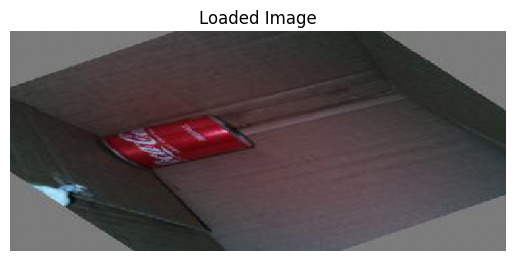

1/1 [==============================] - 0s 72ms/step


Maximum Probability:  0.99927336
Classified: FANTA 



-------------------Individual Probability--------------------------------

BOGA : 0.0 %
COCACOLA : 0.0 %
FANTA : 99.93 %
ORANGINA : 0.07 %
SPRITE : 0.0 %
APPLA : 0.0 %


In [ ]:
predict("/content/drive/MyDrive/BRANDCAN/COCACOLA/aug_0_6151009.jpg")

In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('/content/drive/MyDrive/BRANDCAN/COCACOLA/aug_0_6151009.jpg')

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the color ranges you want to extract (in HSV format)
color_ranges = [
    ((0, 50, 50), (10, 255, 255)),    # red
    ((36, 25, 25), (70, 255, 255)),   # green
    ((100, 25, 25), (140, 255, 255)), # blue
    ((20, 100, 100), (30, 255, 255)), # yellow
    ((0, 100, 100), (20, 255, 255))   # orange
]

# Initialize an empty list to store the extracted color features
color_features = []

# Loop over the color ranges and extract features for each range
for (lower, upper) in color_ranges:
    # Create a binary mask for pixels within the color range
    mask = cv2.inRange(hsv_image, lower, upper)

    # Compute the color histogram for the masked region
    hist = cv2.calcHist([hsv_image], [0], mask, [256], [0, 256])

    # Normalize the histogram to sum to 1
    hist /= hist.sum()

    # Append the histogram to the feature vector
    color_features.extend(hist.flatten())

# Convert the feature vector to a numpy array
color_features = np.array(color_features)


<ipython-input-30-13a2cb5b79ff>:31: RuntimeWarning: invalid value encountered in true_divide
  hist /= hist.sum()


In [ ]:
color_features

array([0.6089785 , 0.16742572, 0.08284537, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('//content/drive/MyDrive/BRANDCAN/ORANGINA/aug_0_1700375.jpg')

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the color ranges you want to extract (in HSV format)
color_ranges = [
    ((0, 50, 50), (10, 255, 255)),    # red
    ((36, 25, 25), (70, 255, 255)),   # green
    ((100, 25, 25), (140, 255, 255)), # blue
    ((20, 100, 100), (30, 255, 255)), # yellow
    ((0, 100, 100), (20, 255, 255))   # orange
]

# Initialize an empty list to store the extracted color features
color_features = []

# Loop over the color ranges and extract features for each range
for (lower, upper) in color_ranges:
    # Create a binary mask for pixels within the color range
    mask = cv2.inRange(hsv_image, lower, upper)

    # Compute the color histogram for the masked region
    hist = cv2.calcHist([hsv_image], [0], mask, [256], [0, 256])

    # Normalize the histogram to sum to 1
    hist /= hist.sum()

    # Append the histogram to the feature vector
    color_features.extend(hist.flatten())

# Convert the feature vector to a numpy array
color_features = np.array(color_features)
np.argmax(color_features)


788

In [ ]:
import cv2



In [ ]:
pip install tesseract


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562572 sha256=86e3301ae6c683628a355ad5f837650c4f85eb3107fa4f5c8a2e1b75f1a0f3df
  Stored in directory: /root/.cache/pip/wheels/71/c9/aa/698c579693e83fdda9ad6d6f0d8f61ed986e27925ef576f109
Successfully built tesseract
